# ML Pipeline

This notebook simply introduces to some of the concepts to be considered when designing a ML pipeline. We will play with the Titanic dataset to illustrate the sequence of tasks to be accomplished to solve a typical ML problem.

We will leverage most of our routines in the SKLearn API to build the pipelines and some of the tasks (including the model), but typically you will also need `pandas` and `numpy`. Optionally, you will find useful to plot results using `matplotlib` or `seaborn`.

Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn")

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Read the data

In [30]:
url="https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)
data.head().T #Tranpose to see whether all the columns have loaded properly

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


## Quantitative/Qualitative information about data

We need to take a look at the data shape, column types, correlations, missing values, etc.. Many different ways of doing it in Python, and many libraries to help you with. Let's try `pandas_profiling` [library](https://github.com/ydataai/pandas-profiling).

In [ ]:
#!pip3 install pandas_profiling --upgrade
#!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(data)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data['Cabin'].describe() 

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

A different way of looking to the histograms, simpler, though not so informative, using pandas ability to plot the data that DataFrame holds.

In [31]:
# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


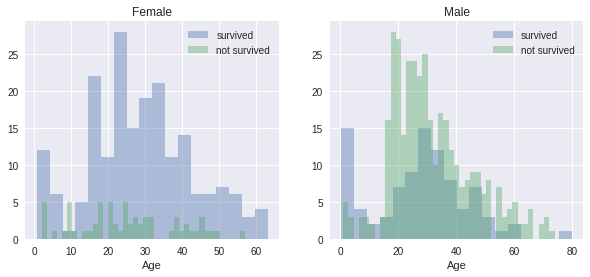

In [5]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = data[data['Sex']=='female']
men = data[data['Sex']=='male']

ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

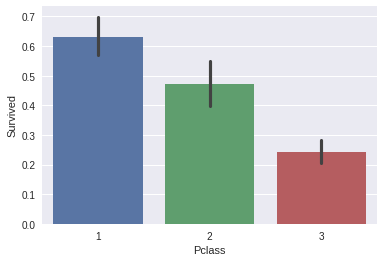

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=data)

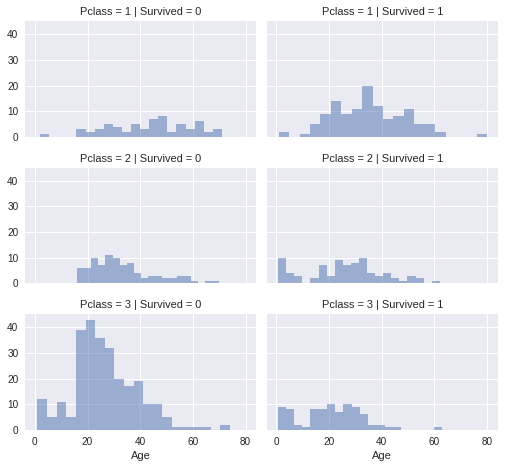

In [ ]:
grid = sns.FacetGrid(data, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## Basic Data Cleaning

We've missing values in Age, Embarked and Cabin features. Let's count them.

In [ ]:
pd.isnull(data).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


One possible strategy is to impute, but we don't really know if that will work, so I decide to drop those missing values, since they're only two.

I'm also getting rid of `Cabin` and `Ticket` since they are noise at this moment.

In [32]:
#Alternatively, I'd like to extract deck information from Cabin and then delete but that would give me 687 missing values regardless
data.drop(labels=['Cabin', 'Ticket'], axis=1, inplace=True)
data = data[data.Embarked.notna()].copy(deep=True)
pd.isnull(data).sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

### Age NULLs

We've a problem with that column... so what can we do? Count them, first.

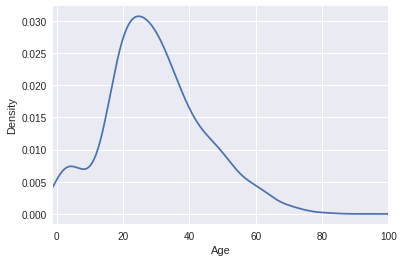

In [ ]:
data.Age.plot.density()
plt.xlim(-1, 100); plt.xlabel("Age")
plt.show()

## Imputation 

Let's work on `Age`. We should build a powerful predictor that will help us to assign the missing values for Age column, but since we're starting with ML, let's simply use the median of the age (per gender) to fill them.

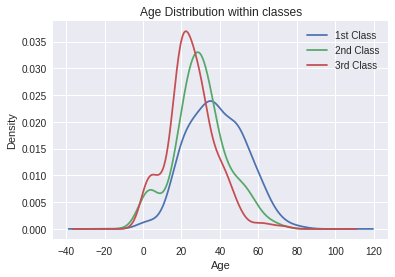

In [7]:
data.Age[data.Pclass == 1].plot(kind='kde')    
data.Age[data.Pclass == 2].plot(kind='kde')
data.Age[data.Pclass == 3].plot(kind='kde')

plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

In [33]:
#I'm also going to consider median age according to Pclass in addition to Sex; (assumption: wealthier are older and Pclass will be different)
med_age_males_1 = data[(data.Age.notnull()) & (data.Sex == "male") & (data.Pclass == 1)]['Age'].median()
med_age_males_2 = data[(data.Age.notnull()) & (data.Sex == "male") & (data.Pclass == 2)]['Age'].median()
med_age_males_3 = data[(data.Age.notnull()) & (data.Sex == "male") & (data.Pclass == 3)]['Age'].median()

med_age_females_1 = data[(data.Age.notnull()) & (data.Sex == "female") & (data.Pclass == 1)]['Age'].median()
med_age_females_2 = data[(data.Age.notnull()) & (data.Sex == "female") & (data.Pclass == 2)]['Age'].median()
med_age_females_3 = data[(data.Age.notnull()) & (data.Sex == "female") & (data.Pclass == 3)]['Age'].median()

data.loc[(data.Age.isnull()) & (data.Sex == "male") & (data.Pclass == 1), 'Age'] = med_age_males_1
data.loc[(data.Age.isnull()) & (data.Sex == "male") & (data.Pclass == 2), 'Age'] = med_age_males_2
data.loc[(data.Age.isnull()) & (data.Sex == "male") & (data.Pclass == 3), 'Age'] = med_age_males_3

data.loc[(data.Age.isnull()) & (data.Sex == "female") & (data.Pclass == 1), 'Age'] = med_age_females_1
data.loc[(data.Age.isnull()) & (data.Sex == "female") & (data.Pclass == 2), 'Age'] = med_age_females_2
data.loc[(data.Age.isnull()) & (data.Sex == "female") & (data.Pclass == 3), 'Age'] = med_age_females_3

Let's see how `Age` looks like now, using a density plot (`data.plot.density`)

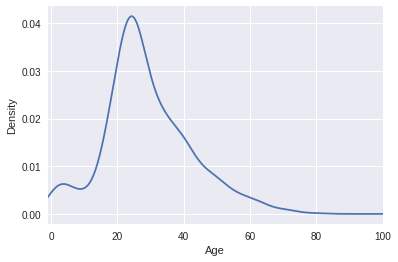

In [9]:
data.Age.plot.density()
plt.xlim(-1, 100); plt.xlabel("Age")
plt.show()

## EDA - Relationships between variables.

Start by knowing what is the relation between Fare and Age for those who survived and those who didn't. Use `matplotlib` _scatter_ plot withe the `color` argument taking the values of the field `Survived`. To plot the legend we need to do something like:

```python
label_names = [] # array with names of labels, sorted.
plt.legend(handles=scatter.legend_elements()[0], labels=label_names, title="Lengen Title")
```

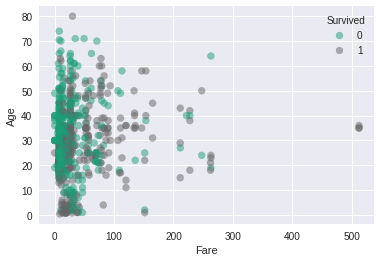

In [10]:
plt.figure(figsize=(6, 4))
fare_names = [str(data.Survived.unique()[i]) for i in data.Survived.unique()]
scatter = plt.scatter(data['Fare'], data['Age'], 
    c=data['Survived'],
    alpha=0.5, cmap='Dark2')
plt.legend(handles=scatter.legend_elements()[0], labels=fare_names, title="Survived")
plt.xlabel("Fare"); plt.ylabel("Age")
plt.show();

But we can make a different plot for each class, using the `pandas.plot.scatter` method, much easily. Let's plot three with the different classes (`Pclass`) values, so we get an idea of how many people survived from 1st, 2nd and 3rd class.

Tip: Use `colormap=Dark2` or any other variant in matplotlib, to change default colors.

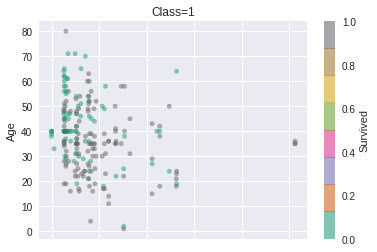

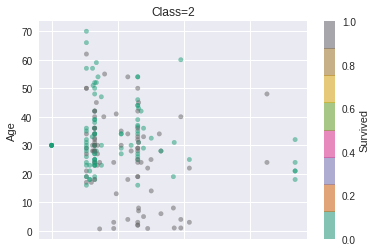

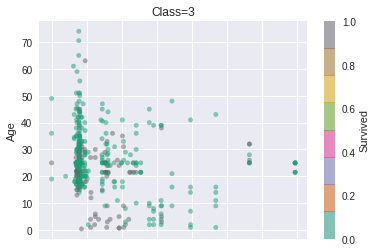

In [11]:
data[data['Pclass']==1].plot.scatter(x="Fare", y="Age", c="Survived", colormap="Dark2", alpha=0.5, title="Class=1")
data[data['Pclass']==2].plot.scatter(x="Fare", y="Age", c="Survived", colormap="Dark2", alpha=0.5, title="Class=2")
data[data['Pclass']==3].plot.scatter(x="Fare", y="Age", c="Survived", colormap="Dark2", alpha=0.5, title="Class=3");

Work now with Fare and Age, for the different genders.

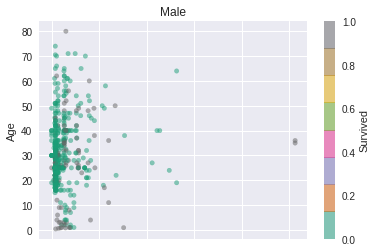

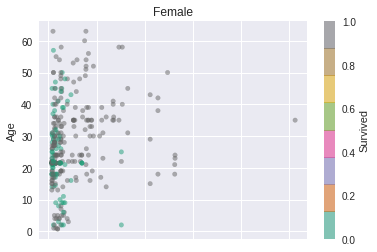

In [14]:
data[data['Sex']=='male'].plot.scatter("Fare", "Age", c="Survived", colormap="Dark2", alpha=0.5, title="Male")
data[data['Sex']=='female'].plot.scatter("Fare", "Age", c="Survived", colormap="Dark2", alpha=0.5, title="Female")

How about boxplots to see how the people from the different classes and Ages survived? Maybe this plot is more informative??

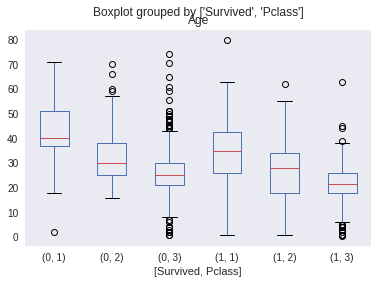

In [15]:
data.boxplot("Age", by=["Survived", "Pclass"], grid=False)

And finally, histograms of how many people survived, but grouping by gender and class.

Tip: play with the `layout=(2, 3)` or the `sharey=True` arguments.

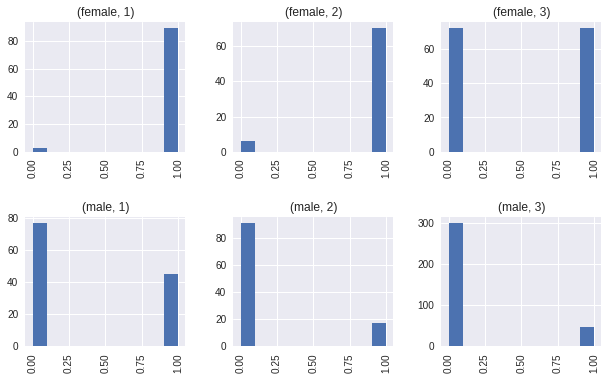

In [16]:
data.hist("Survived", by=["Sex", "Pclass"], figsize=(10,6), layout=(2, 3)); # sharey=True

What is the age distribution per class? We can use `df.plot(kind='kde')`.

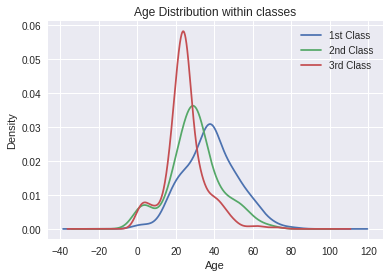

In [28]:
data.Age[data.Pclass == 1].plot(kind='kde')    
data.Age[data.Pclass == 2].plot(kind='kde')
data.Age[data.Pclass == 3].plot(kind='kde')

plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

## Feature Engineering

**Family size**

Given that the variable `Parch`is the nr of Parents/Children aboard, and `SibSp` is the number of siblings/spouses aboard, we can build a feature that tell us if you've family aboard, and what is its size.

In [34]:
data["FamilyMembers"] = data["SibSp"] + data["Parch"]+1
print(data["FamilyMembers"].value_counts())

1     535
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilyMembers, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


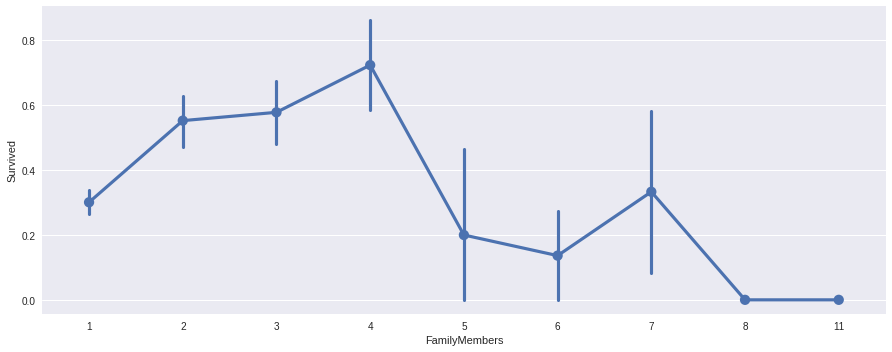

In [35]:
axes = sns.factorplot('FamilyMembers','Survived', 
                      data=data, aspect = 2.5)

We can also build a categorical that tell us if someone is alone in the boat, or whether has a normal family size (say <=4) or large one (>4).

Tip: `df.loc[condition, new_field] = 'value'`

In [36]:
data.loc[data["FamilyMembers"] == 1, "FamSize"] = 'single'
data.loc[(data["FamilyMembers"] > 1) & (data["FamilyMembers"] < 5), "FamSize"] = 'normal'
data.loc[data["FamilyMembers"] >= 5, "FamSize"] = 'large'
data.FamSize.value_counts()

single    535
normal    292
large      62
Name: FamSize, dtype: int64

How many people survived, based on this new criteria of family size?? Use a histogram to plot results.

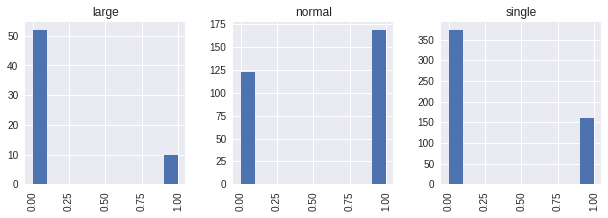

In [37]:
data.hist("Survived", by="FamSize", figsize=(10,3), layout=(1,3));

### **Convert** categorical into numericals by using OneHotEncoder

We will use pandas `get_dummies`, and we need to do it for `Sex`, `FamSize` and `Embarked`. Don't forget to remove original categorical variables after dummification.

In [38]:
data['male'] = pd.get_dummies(data.Sex, drop_first=True)
data.drop('Sex', axis=1, inplace=True)

In [39]:
data.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Fare,7.25,71.2833,7.925,53.1,8.05
Embarked,S,C,S,S,S
FamilyMembers,2,2,1,2,1


In [40]:
newcols = pd.get_dummies(data.FamSize, drop_first=True, prefix="fam") #Doubt: drop_first=True is removing fam_large. Why? 
#Would it be better to have a binary variable called 'alone' if we are not considering size of the family?
data = pd.concat([data, newcols], axis=1)
data.drop(['FamSize','SibSp','Parch'], axis=1, inplace=True)

In [41]:
data.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Fare,7.25,71.2833,7.925,53.1,8.05
Embarked,S,C,S,S,S
FamilyMembers,2,2,1,2,1


In [42]:
newcols = pd.get_dummies(data.Embarked, drop_first=True, prefix="Port") 
data = pd.concat([data, newcols], axis=1)
data.drop(['Embarked'], axis=1, inplace=True)

In [43]:
data.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Fare,7.25,71.2833,7.925,53.1,8.05
FamilyMembers,2,2,1,2,1
male,1,0,0,0,1


## Baseline

What is the performance of the basic model with no added features?

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


features = ["Pclass", "male", "Age", "Fare", "Port_Q", "Port_S"]
target = "Survived"

X_train = data[features]
y_train = data[target]
X_training, X_valid, y_training, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=4321)

In [55]:
#Linear Regression
linreg = LinearRegression()
linreg.fit(X_training, y_training)
predictions = np.array(linreg.predict(X_valid))
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = accuracy_score(y_valid, predictions)
accuracy

0.797752808988764

In [56]:
#Logistic Regression
logreg_clf = LogisticRegression()
logreg_clf.fit(X_training, y_training)
pred_logreg = logreg_clf.predict(X_valid)
acc_logreg = accuracy_score(y_valid, pred_logreg)

print(acc_logreg)

0.7921348314606742


## Model Construction and Evaluation

Ensure reproducibility

In [70]:
np.random.seed(1234)

Define what are your features and target variable, and build your training and test sets.

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [71]:
features = ["Pclass", "male", "Age", "Fare", "Port_Q", "Port_S",
            "fam_single",'fam_normal']
target = "Survived"

X_train = data[features]
y_train = data[target]
X_training, X_valid, y_training, y_valid = train_test_split(
    X_train, y_train, test_size=0.2)

Linear Regression

In [72]:
linreg = LinearRegression()
linreg.fit(X_training, y_training)
predictions = np.array(linreg.predict(X_valid))
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = accuracy_score(y_valid, predictions)
accuracy

0.7921348314606742

Logistic Regression

In [73]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_training, y_training)
pred_logreg = logreg_clf.predict(X_valid)
acc_logreg = accuracy_score(y_valid, pred_logreg)

print(acc_logreg)

0.8089887640449438
